# Implementing Golf Putting Models in Pyro

There has been a lot of interest in recent years in probabilistic programming languages (PPLs), which essentially enable one to create bespoke Bayesian generative models to solve all kinds of interesting statistical problems. A newer addition to the PPL space is [Uber's Pyro](http://pyro.ai/), which is a Python library built on top of [(Facebook's) PyTorch](https://ai.facebook.com/tools/pytorch/). The website spells out its selling points quite well:

>Pyro is a universal probabilistic programming language (PPL) written in Python and supported by PyTorch on the backend. Pyro enables flexible and expressive deep probabilistic modeling, unifying the best of modern deep learning and Bayesian modeling. It was designed with these key principles:

- Universal: Pyro can represent any computable probability distribution.
- Scalable: Pyro scales to large data sets with little overhead.
- Minimal: Pyro is implemented with a small core of powerful, composable abstractions.
- Flexible: Pyro aims for automation when you want it, control when you need it.

Check out the [Uber Engineering blog post announcement](https://eng.uber.com/pyro/) for a better overview and some more technical details.

On my journey towards Pyro proficiency, I thought it would be a good idea to translate some models from other PPLs to Pyro. So in this post I'm going to discuss the fun problem of modeling the efficiency of professional golf putting. I discovered this problem while watching a YouTube video, and went back and read the implementation of the model in both [Stan](https://mc-stan.org/users/documentation/case-studies/golf.html) and [PyMC](https://docs.pymc.io/notebooks/putting_workflow.html). What's interesting about these golf models is that they show how one can improve from a simple logistic regression by adding actual physical considerations of the problem at hand. This, after all, is the raison d'etre for PPLs. Anyway, if you're interested, I highly recommend reading one (or both) of the previous implementations for more technical explanation of the underlying physics. 

Now let's walk through some Pyro code! First we'll do some imports.

In [2]:
import io

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

%matplotlib inline
sns.set_style("darkgrid")

/home/evan/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Next we'll define the putting dataset which can be found in those previous blog posts. 

In [8]:
"""
The data set consists of 3 columns: [x] is the distance from the hole;
[n] is the total number of attempts; [y] is the total number of made putts. 
It should be noted that the data is obviously binned into buckets spaced
roughly 1 foot apart.
"""

new_data = """
x n y
0.28 45198 45183
0.97 183020 182899
1.93 169503 168594
2.92 113094 108953
3.93 73855 64740
4.94 53659 41106
5.94 42991 28205
6.95 37050 21334
7.95 33275 16615
8.95 30836 13503
9.95 28637 11060
10.95 26239 9032
11.95 24636 7687
12.95 22876 6432
14.43 41267 9813
16.43 35712 7196
18.44 31573 5290
20.44 28280 4086
21.95 13238 1642
24.39 46570 4767
28.40 38422 2980
32.39 31641 1996
36.39 25604 1327
40.37 20366 834
44.38 15977 559
48.37 11770 311
52.36 8708 231
57.25 8878 204
63.23 5492 103
69.18 3087 35
75.19 1742 24
"""

data = pd.read_csv(io.StringIO(new_data),sep=' ')
data['pct'] = data['y']/data['n']
data.head()

,x,n,y,pct
0,0.28,45198,45183,0.999668
1,0.97,183020,182899,0.999339
2,1.93,169503,168594,0.994637
3,2.92,113094,108953,0.963384
4,3.93,73855,64740,0.876582


Here is a plot of the putting success as a function of distance.

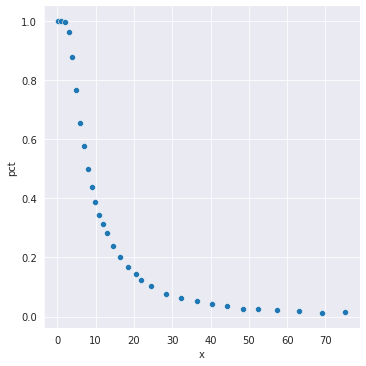

In [12]:
sns.relplot(data=data, x="x", y="pct")

## Logistic Regression Model

The first model we'll recreate in Pyro is the logistic regression model. This model has two parameters to be determined `a` and `b`, which will be found by variation inference. The model is defined as a plane old Python function.

In [13]:
def model(data):
    a = pyro.sample("a", dist.Normal(0,1))
    b = pyro.sample("b", dist.Normal(0, 1))
    x = torch.Tensor(data["x"])
    y = torch.Tensor(data["y"])
    n = torch.Tensor(data["n"])
    with pyro.plate("data", len(data)):
        pyro.sample("p", dist.Binomial(n, logits=a+b*x), obs=y)
        return torch.sigmoid(a+b*x)

Any time we want to create latent variables to be sampled from we use the `pyro.sample` function, which accepts a string as a name (used internally by Pyro to track each parameter) and a distribution from the Torch or Pyro library. We use another `pyro.sample` statement with an `obs` argument to pass in our actual observations from the golf dataset. In this example the calculations are all vectorized so we don't have to explicitly loop through the rows. The `with` statement is not really necessary in this example, but in theory, it helps Pyro do more efficient inference calculations by marking the data as conditionally independent. The values passed into the `return` statement will enable us to do some plotting later. 

So now that we have created the model, the next step is to define a function that Pyro refers to as a `guide`. The guide is how Pyro does variational inference, which to describe way too briefly is a way of approximating the posterior distribution `p` by optimization of some other function `q`. In many cases you can use Pyro's "black box" variational inference algorithm, which means you don't have to explicitly define the guide. In fact, for all 3 of these models I used this approach. I'm still wrapping my head around writing explicit guides on my own.

In [14]:
guide = AutoDiagonalNormal(model)

That's all you have to do! From here on out, it's easy peasy. We simply choose one of Pyro's built-in optimizers and a loss function. You may have heard of `Adam` before if you have done any deep learning. The `ELBO` loss is a bit more obscure. It stands for "Evidence Lower Bound" and can be derived using the Kullback-Leibler Divergence to compare the posterior distribution with our variational distribution (or guide in this case). The important point I want to emphasize here is that variational inference is essentially just optimization, which means it can be performed much, much faster than sampling algorithms that are more typical of PPLs (eg MCMC, NUTS, HMC, etc). The downside to variational approaches is they are approximations whereas sampling algorithms can eventually converge on an exact posterior. For our purposes VI is more than good enough as you'll see!

In [15]:
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

`SVI` is Pyro's class for performing stochastic variational inference. It takes a model, guide, optimizer, and loss function, all of which we just defined. Now we perform the inference steps.

In [16]:
pyro.clear_param_store()
for j in range(1000):
    # calculate the loss and take a gradient step
    loss = svi.step(data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 14468.9522
[iteration 0101] loss: 5330.1439
[iteration 0201] loss: 2319.9911
[iteration 0301] loss: 2401.6161
[iteration 0401] loss: 2480.4197
[iteration 0501] loss: 2451.2360
[iteration 0601] loss: 2336.4442
[iteration 0701] loss: 2363.1881
[iteration 0801] loss: 2294.1168
[iteration 0901] loss: 2508.3753


Let's look at the values of the parameters `a` and `b`:

In [17]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([ 2.8320, -0.2529])
AutoDiagonalNormal.scale tensor([0.0282, 0.0082])


The `.loc` parameters are the means of `a` and `b` and the `.scale` parameters are the standard deviations. These are very close to the values given in the two blog posts, which is good to see because those two posts use the more exact sampling algorithms for inference.

Now let's generate some samples from the posterior distribution and plot our model vs the original data.

In [19]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800, return_sites=("obs",'_RETURN'))
samples = predictive(data)
pred_summary = summary(samples)

data['pct_fit'] = pred_summary['_RETURN']['mean']
data['lo'] = pred_summary['_RETURN']['5%']
data['hi'] = pred_summary['_RETURN']['95%']
data.head(5)

,x,n,y,pct,pct_fit,lo,hi
0,0.28,45198,45183,0.999668,0.940438,0.937973,0.942971
1,0.97,183020,182899,0.999339,0.929873,0.926846,0.932950
2,1.93,169503,168594,0.994637,0.912277,0.908170,0.916318
3,2.92,113094,108953,0.963384,0.890043,0.884190,0.895799
4,3.93,73855,64740,0.876582,0.862416,0.854141,0.870438


Text(0, 0.5, '% putts made')

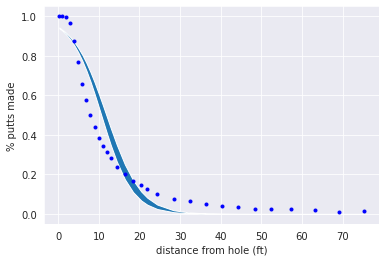

In [28]:
fig, ax = plt.subplots()
ax.plot(data['x'],data['pct'], 'b.')
ax.fill_between(data['x'], data['lo'], data['hi'])
plt.xlabel('distance from hole (ft)')
plt.ylabel('% putts made')

As you can see here the logistic regression model only gives a rough approximation. Let's try something a bit more sophisticated.

## Angle Model

So the next model we're going to build assumes that putting errors are related to the angle of the trajectory of the ball to the cup. The shorter the distance of the ball to the cup the more tolerance there is for this error. The golfer tries to hit the ball perfectly straight but we assume in the model that errors in the angle are normally distributed with a standard deviation $\sigma$. 

In [30]:
def model(data):
    r = torch.tensor(1.68/24) # using torch.Tensor() here results in: TypeError: new(): data must be a sequence (got float)
    R = torch.tensor(4.25/24) 
    sigma = pyro.sample("sigma", dist.Uniform(0,1))
    x = torch.Tensor(data["x"])
    y = torch.Tensor(data["y"])
    n = torch.Tensor(data["n"])
    threshold_angle = torch.Tensor(np.arcsin((R-r) / x))
    p = torch.Tensor(2.0*dist.Normal(0,1).cdf(threshold_angle / sigma) - 1.0)
    with pyro.plate("data", len(data)):
        pyro.sample("succ", dist.Binomial(n, p), obs=y)
        return p

In this model `r` is the radius of the golf ball (in feet), `R` is the radius of the cup, sigma is the latent variable for $\sigma$ that we will model with a uniform prior, and the `threshold_angle` describes the angle needed to make a putt. 

Now we just carry out the inference steps as before.

In [31]:
guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
for j in range(5000):
    # calculate the loss and take a gradient step
    loss = svi.step(data)
    if j % 500 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 57394.9396
[iteration 0501] loss: 334.5843
[iteration 1001] loss: 340.3694
[iteration 1501] loss: 335.3992
[iteration 2001] loss: 334.2980
[iteration 2501] loss: 334.9189
[iteration 3001] loss: 337.8373
[iteration 3501] loss: 335.2401
[iteration 4001] loss: 334.2563
[iteration 4501] loss: 334.5344


In [35]:
guide.requires_grad_(False)

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800, return_sites=("succ","sigma","_RETURN"))
samples = predictive(data)
pred_summary = summary(samples)

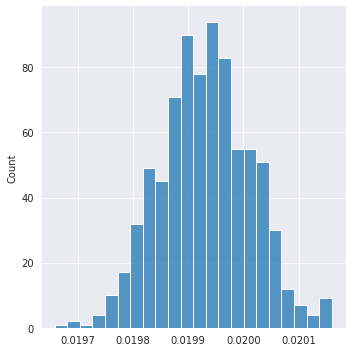

In [36]:
sigma = samples['sigma'].numpy().squeeze()
sns.displot(x=sigma, kind='hist')

In [38]:
data['pct_fit'] = pred_summary['_RETURN']['mean']
data['lo'] = pred_summary['_RETURN']['5%']
data['hi'] = pred_summary['_RETURN']['95%']
data.head(5)

,x,n,y,pct,pct_fit,lo,hi
0,0.28,45198,45183,0.999668,1.000000,1.000000,1.000000
1,0.97,183020,182899,0.999339,1.000000,1.000000,1.000000
2,1.93,169503,168594,0.994637,0.994648,0.994341,0.994945
3,2.92,113094,108953,0.963384,0.934281,0.932491,0.936038
4,3.93,73855,64740,0.876582,0.828453,0.825623,0.831251


Text(0, 0.5, '% putts made')

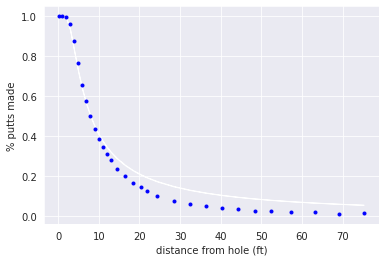

In [40]:
fig, ax = plt.subplots()
ax.plot(data['x'],data['pct'], 'b.')
ax.fill_between(data['x'], data['lo'], data['hi'])
plt.xlabel('distance from hole (ft)')
plt.ylabel('% putts made')

Interestingly, the fit is pretty good only out to about 10 feet. The next clever addition to the model is to take into account how hard the ball is hit. 

## Accounting for Putt Strength

This adds a few new terms to the model. I highly recommend reading the previously mentioned blog posts if you want to understand the physical explanation underlying the rational for adding these terms. 

In [42]:
def model(data):
    r = torch.tensor(1.68/24) # using torch.Tensor() here results in: TypeError: new(): data must be a sequence (got float)
    R = torch.tensor(4.25/24) 
    overshot = torch.tensor(1) # 1 foot
    distance_tolerance = torch.tensor(3)
    sigma_angle = pyro.sample("sigma_angle", dist.HalfNormal(1))
    sigma_distance = pyro.sample("sigma_distance", dist.HalfNormal(1))
    x = torch.Tensor(data["x"])
    y = torch.Tensor(data["y"])
    n = torch.Tensor(data["n"])
    threshold_angle = torch.Tensor(np.arcsin((R-r) / x))
    p_angle = torch.Tensor(2.0*dist.Normal(0,1).cdf(threshold_angle / sigma_angle) - 1.0)
    p_distance = torch.Tensor(dist.Normal(0,1).cdf((distance_tolerance - overshot)/((x + overshot)*sigma_distance)) -
                             dist.Normal(0,1).cdf((- overshot) / ((x + overshot)*sigma_distance)))
    p = p_angle * p_distance
    with pyro.plate("data", len(data)):
        pyro.sample("succ", dist.Binomial(n, p), obs=y)
        return p

Clearly, this got quite a bit more complicated, but actually it was pretty straightforward to implement in Pyro. Now we just go through the inference once again.

In [43]:
guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
for j in range(5000):
    # calculate the loss and take a gradient step
    loss = svi.step(data)
    if j % 500 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 86526.8937
[iteration 0501] loss: 71.6018
[iteration 1001] loss: 67.4359
[iteration 1501] loss: 55.3861
[iteration 2001] loss: 52.0381
[iteration 2501] loss: 53.0715
[iteration 3001] loss: 54.5639
[iteration 3501] loss: 51.7999
[iteration 4001] loss: 52.1124
[iteration 4501] loss: 52.5968


In [44]:
guide.requires_grad_(False)

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800, return_sites=("succ","sigma_angle","sigma_distance","_RETURN"))
samples = predictive(data)
pred_summary = summary(samples)

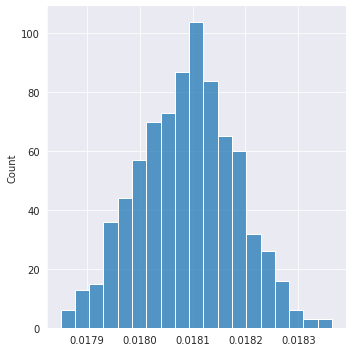

In [47]:
sigma_angle = samples['sigma_angle'].numpy().squeeze()
sns.displot(x=sigma_angle, kind='hist')

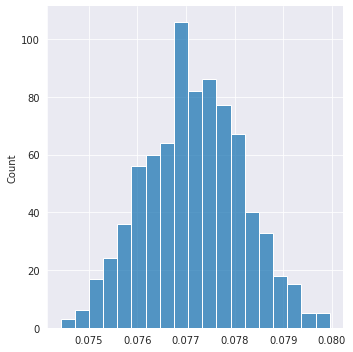

In [48]:
sigma_distance = samples['sigma_distance'].numpy().squeeze()
sns.displot(x=sigma_distance, kind='hist')

In [45]:
data['pct_fit'] = pred_summary['_RETURN']['mean']
data['lo'] = pred_summary['_RETURN']['5%']
data['hi'] = pred_summary['_RETURN']['95%']
data.head(5)

,x,n,y,pct,pct_fit,lo,hi
0,0.28,45198,45183,0.999668,1.000000,1.000000,1.000000
1,0.97,183020,182899,0.999339,1.000000,1.000000,1.000000
2,1.93,169503,168594,0.994637,0.997844,0.997652,0.998022
3,2.92,113094,108953,0.963384,0.956956,0.955159,0.958650
4,3.93,73855,64740,0.876582,0.864331,0.860999,0.867608


Text(0, 0.5, '% putts made')

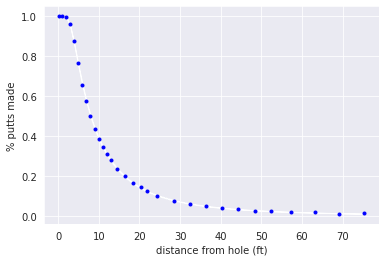

In [46]:
fig, ax = plt.subplots()
ax.plot(data['x'],data['pct'], 'b.')
ax.fill_between(data['x'], data['lo'], data['hi'])
plt.xlabel('distance from hole (ft)')
plt.ylabel('% putts made')

Wow! As you can see adding putt strength really improved the fit. Well, that was fun. I hope you can see the usefulness of PPL's and do make an effort to check out Pyro if you decide you're interested in adding a tool like this to your toolbox.